# A vizsgafeladat rövid leírása

A választott feladatom a kaggle Ecommerce Text Classification adatokon alapul, amely online kereskedelemben árult áruk angol nyelvű leírását és árutípus szerinti kategorizálását tartalmazza összesen négy különböző kategóriában. Az adatok elérhetősége: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

A szöveg szavakra (pontosabban szótövekre) bontásához és adatosításához a spacy nyelvfeldolgozó csomagot használjuk, ennek az angol nyelvre kidolgozott alapcsomagját, valamint a szófelhő rajzolásához a wordcloud csomagot letöltöttem.

Hivatkozások:
A kódok nagy része a tanfolyam tananyagából és feladataiból jön, más része egyéb internetes forrásokból, pl. innen: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
! python -m spacy download en_core_web_sm
! pip install wordcloud
! pip install umap-learn


# Az adatok letöltése


In [2]:
! wget https://zenodo.org/record/3355823/files/ecommerceDataset.csv?download=1

--2022-11-30 20:18:24--  https://zenodo.org/record/3355823/files/ecommerceDataset.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36949114 (35M) [text/plain]
Saving to: ‘ecommerceDataset.csv?download=1’

ecommerceDataset.cs 100%[===================>]  35.24M  17.0MB/s    in 2.1s    

2022-11-30 20:18:28 (17.0 MB/s) - ‘ecommerceDataset.csv?download=1’ saved [36949114/36949114]



Az adattábla beolvasása

In [3]:
import pandas as pd

ecomm = pd.read_csv('ecommerceDataset.csv?download=1', sep=',', names=('category','description'))

A fájl legfontosabb jellemzői:

In [16]:
print(ecomm.head())
print("\n")
print(ecomm.tail())
print("\n")
print(ecomm.info())
print("\n")
print(ecomm.shape)

ecomm.describe()

    category                                        description
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...


          category                                        description
50420  Electronics  Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421  Electronics  CrossBeats Wave Waterproof Bluetooth Wireless ...
50422  Electronics  Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423  Electronics  Samsung Guru FM Plus (SM-B110E/D, Black) Colou...
50424  Electronics                   Micromax Canvas Win W121 (White)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0

,category,description
count,50425,50424
unique,4,27802
top,Household,Think & Grow Rich About the Author NAPOLEON HI...
freq,19313,30


A category változóból csinálunk egy numerikus változatot is a modellezéshez.

In [4]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(ecomm['category'])
 
ecomm["category_num"] = label
 


Mivel a táblában a leírások között vannak azonosak, töröljük a duplikátumokat, és van egy olyan sor is, ahol a kategóriához nincs leírás, azt is töröljük.

In [5]:
ecomm.drop_duplicates(inplace=True, ignore_index=True)
ecomm.dropna(inplace=True)
ecomm.describe(include='all')

,category,description,category_num
count,27802,27802,27802.000000
unique,4,27802,NaN
top,Household,Paper Plane Design Framed Wall Hanging Motivat...,NaN
freq,10564,1,NaN
mean,NaN,NaN,1.725847
std,NaN,NaN,1.187025
min,NaN,NaN,0.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,2.000000
75%,NaN,NaN,3.000000


Nézzük a kategóriák megoszlását:

In [6]:
print(ecomm['category'].value_counts())
ecomm['category_num'].value_counts()

Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: category, dtype: int64


3    10564
0     6256
1     5674
2     5308
Name: category_num, dtype: int64

Az adatokat felosztom tréning, validációs és teszt adatokra. Ehhez a kategória-változót strátumváltozóként használom, hogy azonos maradjon a különböző kategóriába eső leírások aránya a három résztáblában.

In [7]:
# Import the necessary function from Scikit
from sklearn.model_selection import train_test_split
import random as rn


ecomm_train, ecomm_test_valid = train_test_split(ecomm, test_size=0.2, random_state=13, shuffle=True, stratify=ecomm['category'])
ecomm_test, ecomm_valid = train_test_split(ecomm_test_valid, test_size=0.5, random_state=13, shuffle=True, stratify=ecomm_test_valid['category'])

print(len(ecomm_train), len(ecomm_valid), len(ecomm_test))
print("\n")
print(ecomm_train['category'].value_counts(normalize=True))
print("\n")
print(ecomm_valid['category'].value_counts(normalize=True))
print("\n")
print(ecomm_test['category'].value_counts(normalize=True))

22241 2781 2780


Household                 0.379974
Books                     0.225035
Clothing & Accessories    0.204083
Electronics               0.190909
Name: category, dtype: float64


Household                 0.380079
Books                     0.225099
Clothing & Accessories    0.203883
Electronics               0.190939
Name: category, dtype: float64


Household                 0.379856
Books                     0.224820
Clothing & Accessories    0.204317
Electronics               0.191007
Name: category, dtype: float64


# A tréning adatok feltárása

A leírások karakterszáma

In [8]:
ecomm_train['length'] = ecomm_train.description.apply(lambda x: len(x))

ecomm_train['length'].describe()

count    22241.000000
mean       701.635403
std       1045.124811
min          4.000000
25%        216.000000
50%        473.000000
75%        921.000000
max      50403.000000
Name: length, dtype: float64

Néhány példa a leghosszabb szövegekből

In [10]:
long_sentences = ecomm_train.loc[(ecomm_train['length']>10000),]
long_sentences

,category,description,category_num,length
16562,Books,"AI Superpowers: China, Silicon Valley, and the...",0,13543
11214,Books,How to Be a Bawse: A Guide to Conquering Life ...,0,14870
12588,Books,Dracula (Enriched Classics) About the Author B...,0,31430
24053,Electronics,Quick Heal Total Security Latest Version - 2 P...,2,12473
16490,Books,"Lean In: Women, Work, and the Will to Lead Rev...",0,15990
12111,Books,"Crazy Rich Asians Review ""A dizzily shopaholic...",0,12291
15200,Books,Quantum Healing: Exploring the Frontiers of Mi...,0,10258
15346,Books,Risk Savvy: How to Make Good Decisions About t...,0,50328
10895,Books,Fault Lines – How Hidden Fractures Still Threa...,0,12387
15350,Books,Risk Savvy: How to Make Good Decisions About t...,0,50403


In [25]:
ecomm_train.loc[26265,"description"]

'Deception Point About the Author Dan Brown is the #1 New York Times bestselling author of The Da Vinci Code and, previously, Digital Fortress, Deception Point, and Angels & Demons. He is a graduate of Amherst College and Phillips Exeter Academy, where he spent time as an English teacher before turning his efforts\xa0to writing full-time. He lives in New England with his wife. Visit his website at DanBrown.com. \t\t\t\t    \t \t\t\t\t\t Excerpt. © Reprinted by permission. All rights reserved. Chapter 1Toulos Restaurant, adjacent to Capitol Hill, boasts a politically incorrect menu of baby veal and horse carpaccio, making it an ironic hotspot for the quintessential Washingtonian power breakfast. This morning Toulos was busy -- a cacophony of clanking silverware, espresso machines, and cellphone conversations.The maitre d\' was sneaking a sip of his morning Bloody Mary when the woman entered. He turned with a practiced smile."Good morning," he said. "May I help you?"The woman was attract

Ezek szinte mind könyvek, amelyekről a teljes leírás és még a mintaoldalak is bekerültek. Ráadásul a két "Electronics" kategória közül az egyik valójában könyv, az adatainkban előfordul félrekategorizálás.

Nézzük meg a rövid leírásokat is:

In [26]:
short_sentences = ecomm_train.loc[(ecomm_train['length']<12),]
short_sentences

,category,description,category_num,length
13846,Books,Dead Heat,0,9
15789,Books,Iady-Era,0,9
12584,Books,Dracula,0,8
11257,Books,Panorama,0,8
13784,Books,Yes!,0,4
11561,Books,#Horror,0,8
15788,Books,Iady Era,0,9
11710,Books,Ramayana,0,9
12636,Books,Essays,0,7
16374,Books,Calculus,0,8


Ezek szintén könyvek, ami azt sejteti, hogy ez a termékfajta a leírások hosszában eléggé nagy szórással fog rendelkezni.

In [27]:
ecomm_train.groupby('category').length.describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Books,5005.0,884.928671,1878.893757,4.0,79.0,467.0,1066.00,50403.0
Clothing & Accessories,4539.0,449.776162,389.191568,4.0,190.5,349.0,560.00,3474.0
Electronics,4246.0,827.451719,780.602590,24.0,275.0,614.5,1210.75,12473.0
Household,8451.0,665.141522,577.542828,18.0,279.0,520.0,900.00,8308.0


# A leggyakoribb szavak - szófelhő

A szófelhőt a teljes tréning adatszettre és kategóriánként is elkészítjük a 150 leggyakoribb szóra.

In [ ]:
def do_wordcloud(text, title):
    from wordcloud import WordCloud
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      background_color='white',
                      colormap='Dark2',
                      collocations=True).generate(text)
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=13)
    plt.show()



[15627313, 5629561, 4434072, 2046072, 3517605]
5


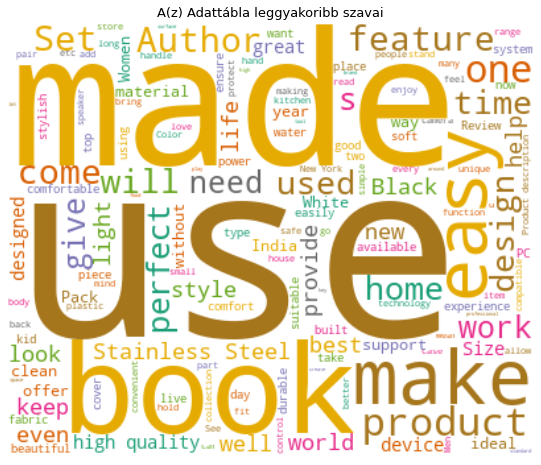

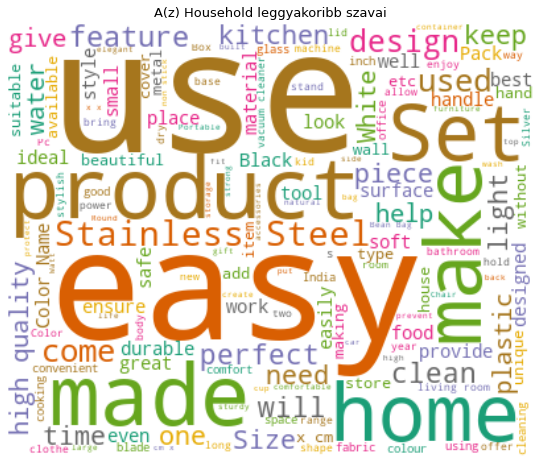

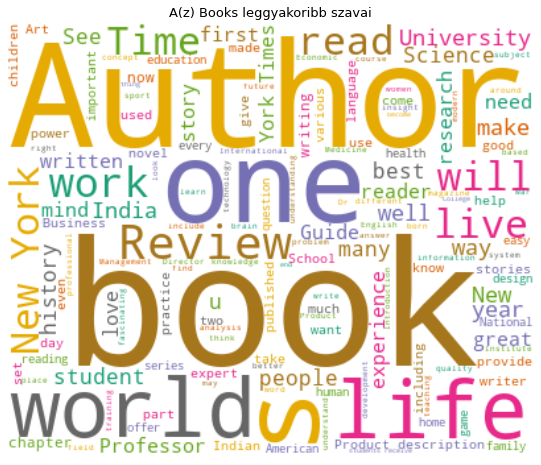

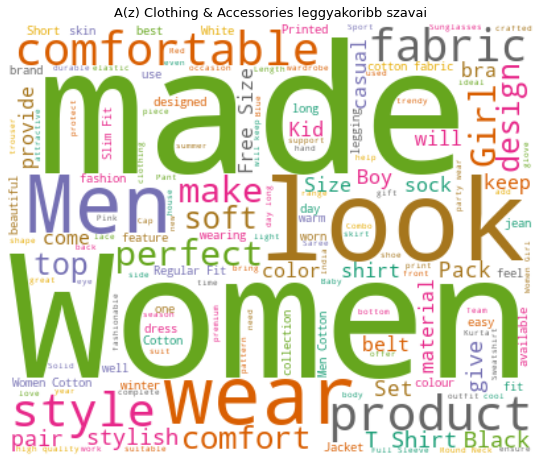

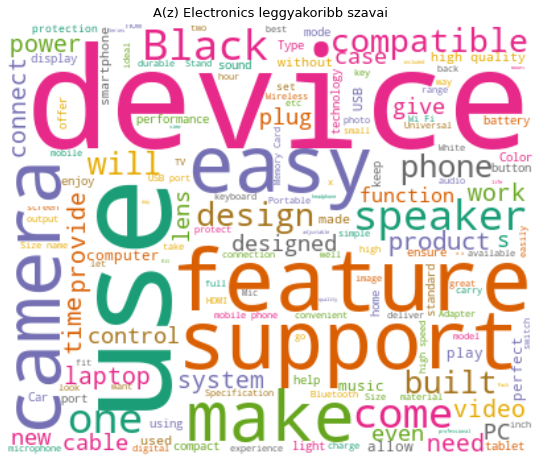

In [ ]:
categories=("Adattábla", "Household", "Books", "Clothing & Accessories", "Electronics")
ecomm_train_string_list=list()

ecomm_train_string=[' '.join(ecomm_train.description)]
ecomm_train_string_list.append(ecomm_train_string[0])

for i in range(1,5):
    ecomm_train_string=[' '.join(ecomm_train.loc[(ecomm_train['category']==categories[i])].description)]
    ecomm_train_string_list.append(ecomm_train_string[0])

lengths = [len(i) for i in ecomm_train_string_list]
print(lengths)
print(len(ecomm_train_string_list))

for i in range(len(ecomm_train_string_list)):
    do_wordcloud(ecomm_train_string_list[i], 'A(z) '+ categories[i] +' leggyakoribb szavai')


# A leírások előfeldolgozása

A szöveg tisztítása, kisbetűs szótövekre alakítás, a stopszavak törlése.

In [9]:
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
ecomm_train["description_clean"] = ecomm_train["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

ecomm_valid["description_clean"] = ecomm_valid["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
ecomm_test["description_clean"] = ecomm_test["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

ecomm_train.head()

,category,description,category_num,length,description_clean
953,Household,Tayyaba Enterprises Pure Sheesham Wooden Rocki...,3,679,tayyaba enterprise pure sheesham wooden rockin...
24365,Electronics,JBL GO Portable Wireless Bluetooth Speaker wit...,2,798,jbl go portable wireless bluetooth speaker mic...
2265,Household,Dkdas Steel Twin Bell Alarm Clock with Night L...,3,735,dkdas steel twin bell alarm clock night led li...
21410,Clothing & Accessories,AV2 Women Solid Feeding/Maternity/Nursing Nigh...,1,589,av2 woman solid feedingmaternitynursing nightd...
8572,Household,Eureka Forbes 100-Watt Car Vaccum Cleaner (Whi...,3,1417,eureka forbes 100watt car vaccum cleaner white...


# A leírások "adatosítása" - Bag of Words  és tf_idf módszerrel

Ebben az esetben a szavak (szótövek) megszámolásával készítünk egy ritka mátrixot. 

In [12]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) 


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma_ for token in nlp(s)], min_df= 0.001) # We ignore the lemmas with low document frequency

tf_idf = TfidfVectorizer(analyzer=lambda s: [token.lemma_ for token in nlp(s)], min_df= 0.001) # We ignore the lemmas with low document frequency

bows_train = cv.fit_transform(ecomm_train.description_clean)
bows_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)

tfidf_train = tf_idf.fit_transform(ecomm_train.description_clean)
tfidf_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
dic_vocabulary = tf_idf.vocabulary_

tfidf_length = tfidf_train.shape[1]
print("Tf_idf length:", tfidf_length)
tfidf_train


BoW length: 5774
Tf_idf length: 5774


<22241x5774 sparse matrix of type '<class 'numpy.float64'>'
	with 999743 stored elements in Compressed Sparse Row format>

In [13]:
bows_valid = cv.transform(ecomm_valid.description_clean)
bows_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test = cv.transform(ecomm_test.description_clean)
bows_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

tfidf_valid = tf_idf.transform(ecomm_valid.description_clean)
tfidf_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
tfidf_test = tf_idf.transform(ecomm_test.description_clean)
tfidf_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement


# Dimenziócsökkentés - az egyes kategóriákat a többitől megkülönböztető szavak kiválasztásával

In [15]:
import numpy as np
X_names = tf_idf.get_feature_names_out()

np.random.choice(X_names, size=100, replace=False)

array(['highdefinition', '1st', 'defect', '14inch', 'inch', 'browse',
       'act', 'notice', 'name32', 'dead', 'eyelet', 'desire', 'usage',
       'upper', 'kind', 'addition', 'attribute', 'moment', 'td', 'pause',
       'shredder', 'discreet', 'eliminate', 'coated', 'attitude',
       'gaming', 'resolve', 'staple', 'shirt', 'relative', 'kill',
       'crease', 'develop', 'asus', 'lifelong', 'conventional', '225',
       'boiler', 'marathon', 'keyboard', 'insect', 'docking', 'blow',
       'unstitched', 'phd', 'onboard', 'btechs', 'rating', 'zebronic',
       'ambient', 'envelope', 'dryer', 'exterior', 'selector',
       'interchangeable', 'illuminate', 'daughter', 'boast', 'complete',
       'ethic', 'san', 'mango', 'mate', 'shooting', 'motorola', '156',
       'park', 'dc', '9h', 'energetic', 'controller', 'grade', '360',
       'hot', 'owner', '3w', 'case', 'movie', 'cooker', 'originally',
       'nearly', 'extract', 'conveniently', 'dough', 'kneelength',
       'always', 'horizont

In [16]:

from sklearn import feature_selection

y = ecomm_train["category"]
X_names = tf_idf.get_feature_names()
p_value_limit = 0.95
ecomm_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(tfidf_train, y==cat)
    ecomm_features = ecomm_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    ecomm_features = ecomm_features.sort_values(["y","score"], 
                    ascending=[True,False])
    ecomm_features = ecomm_features[ecomm_features["score"]>p_value_limit]
X_names = ecomm_features["feature"].unique().tolist()
len(X_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3944

In [17]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(ecomm_features[ecomm_features["y"]==cat]))
   print("  . top features:", ",".join(ecomm_features[ecomm_features["y"]==cat]["feature"].values[:10]))   
   print(" ")

# Books:
  . selected features: 2294
  . top features: 2018,2019,author,award,book,business,chapter,civil,clinical,college
 
# Clothing & Accessories:
  . selected features: 1426
  . top features: ankle,apparel,baby,belt,benetton,blazer,blouse,bodycare,book,boy
 
# Electronics:
  . selected features: 1365
  . top features: 35,adapter,amazonbasic,amplifier,android,audio,aux,bass,battery,binocular
 
# Household:
  . selected features: 2073
  . top features: author,bathroom,bean,bed,blade,book,boy,cake,camera,chair
 


In [18]:
cv_dr = CountVectorizer(vocabulary=X_names) 

tf_idf_dr = TfidfVectorizer( vocabulary=X_names) 

bows_train_dr = cv_dr.fit_transform(ecomm_train.description_clean)
bows_train_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_dr_length = bows_train_dr.shape[1]
print("BoW length after dimension reduction:", bow_dr_length)

tfidf_train_dr = tf_idf_dr.fit_transform(ecomm_train.description_clean)
tfidf_train_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
dic_vocabulary_dr = tf_idf_dr.vocabulary_

tfidf_dr_length = tfidf_train_dr.shape[1]
print("Tf_idf length after dimension reduction:", tfidf_dr_length)
tfidf_train_dr

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


BoW length after dimension reduction: 3944
Tf_idf length after dimension reduction: 3944


<22241x3944 sparse matrix of type '<class 'numpy.float64'>'
	with 730218 stored elements in Compressed Sparse Row format>

In [19]:
bows_valid_dr = cv_dr.transform(ecomm_valid.description_clean)
bows_valid_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test_dr = cv_dr.transform(ecomm_test.description_clean)
bows_test_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

tfidf_valid_dr = tf_idf_dr.transform(ecomm_valid.description_clean)
tfidf_valid_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
tfidf_test_dr = tf_idf_dr.transform(ecomm_test.description_clean)
tfidf_test_dr.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement


# Az adatok ábrázolása nemlineáris dimenziócsökkentéssel

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


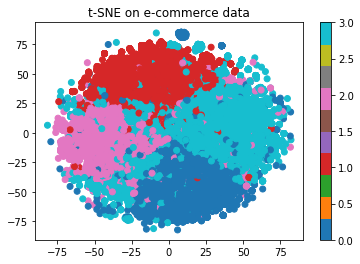

In [67]:
from sklearn import manifold
import matplotlib.pyplot as plt

tsne = manifold.TSNE(n_components=2, init='random', random_state=13)
X_tsne = tsne.fit_transform(bows_train_dr)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=ecomm_train.category_num, cmap="tab10")
plt.title("t-SNE on e-commerce data")
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


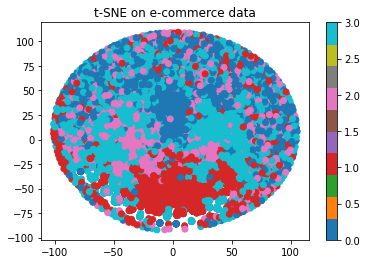

In [80]:
X_tsne = tsne.fit_transform(tfidf_train_dr)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=ecomm_train.category_num, cmap="tab10")
plt.title("t-SNE on e-commerce data")
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


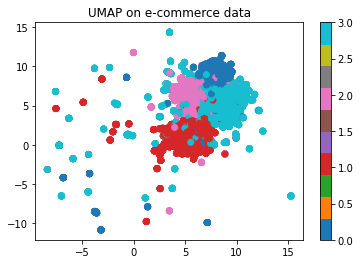

In [68]:
import umap

reducer = umap.UMAP(random_state=13)

X_umap = reducer.fit_transform(bows_train_dr)
X_umap.shape

plt.scatter(X_umap[:,0], X_umap[:,1], c=ecomm_train.category_num, cmap="tab10")
plt.title("UMAP on e-commerce data")
plt.colorbar()
plt.show()

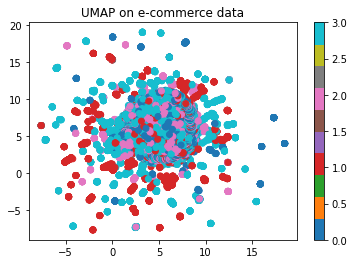

In [93]:
X_umap = reducer.fit_transform(tfidf_train_dr)
X_umap.shape

plt.scatter(X_umap[:,0], X_umap[:,1], c=ecomm_train.category_num, cmap="tab10")
plt.title("UMAP on e-commerce data")
plt.colorbar()
plt.show()

# Naív Bayes modell

In [101]:
from sklearn import naive_bayes
from sklearn import model_selection, naive_bayes, pipeline, manifold, preprocessing

n_bayes = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", tf_idf_dr),  
                           ("classifier", n_bayes)])
## train classifier
model["classifier"].fit(tfidf_train_dr, ecomm_train.category)

## valid
predicted = model["classifier"].predict(tfidf_valid_dr)
predicted_prob = model["classifier"].predict_proba(tfidf_valid_dr)


A modell jóságának ellenőrzése

Accuracy: 0.9302
Auc: 0.9846
Detail:
                        precision    recall  f1-score   support

                 Books       0.97      0.89      0.93       626
Clothing & Accessories       0.94      0.97      0.95       567
           Electronics       0.93      0.90      0.91       531
             Household       0.91      0.95      0.93      1057

              accuracy                           0.93      2781
             macro avg       0.94      0.93      0.93      2781
          weighted avg       0.93      0.93      0.93      2781



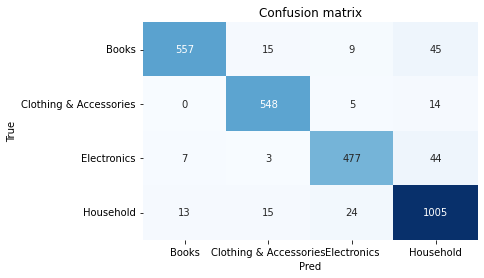

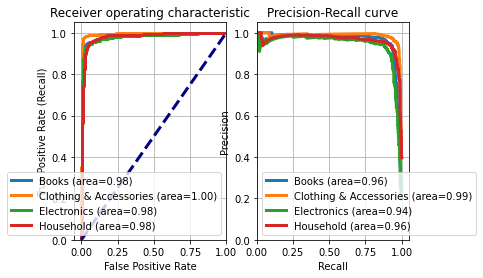

In [102]:
import seaborn as sns
from sklearn import metrics

classes = np.unique(ecomm_valid.category)
y_test_array = pd.get_dummies(ecomm_valid.category, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(ecomm_valid.category, predicted)
auc = metrics.roc_auc_score(ecomm_valid.category, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,4))
print("Auc:", round(auc,4))
print("Detail:")
print(metrics.classification_report(ecomm_valid.category, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(ecomm_valid.category, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Neurális háló modell

És most egy neurális háló modell az adatokra.


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(341)
tf.random.set_seed(453)

In [28]:
# Task parameters

input_size = 3944
n_classes = 4

# Hyperparameters
#################

dropout=True
dropout_rate=0.45

# regularization

lambda_ = 0.001

regularizer = None #?l1(lambda_) 

# weight initialization
initializer = tf.keras.initializers.GlorotNormal()
##########
# Warning! GlorotNormal??
##########
# Possible bug in Keras Initalizers!
# When stuck, use RandomUniform or RandomNormal!

# Model parameters
#################

# hidden_layers
hidden_layer_size = 200
n_hidden_layers = 10
hidden_layer_sizes = n_hidden_layers * [hidden_layer_size]  #ez egy vektor,ami a hidden layer size-okat tartalmazza

# activation function
activation_fun =  'ReLU'

In [29]:
tf.compat.v1.reset_default_graph() # It's good practice to clean and reset everything
clear_session()           # even using Keras


# Model
#######

#Define input with input_size (achtung, vector! :-)
inputs = Input(shape=(input_size,)) 

# Hidden layers

cur_last_layer = inputs

for n, _ in enumerate(hidden_layer_sizes): 
    cur_last_layer = Dense(units=hidden_layer_sizes[n], 
                           activation=activation_fun, 
                           kernel_regularizer=regularizer, 
                           kernel_initializer=initializer, 
                           bias_initializer='zeros')(cur_last_layer)
    if dropout:
        cur_last_layer = Dropout(rate=dropout_rate)(cur_last_layer)


# Softmax 
#Define the predictions!
#Use Softmax!
predictions = Dense(n_classes, activation='softmax')(cur_last_layer)

# Full model
# Instantiate with input and output
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3944)]            0         
                                                                 
 dense (Dense)               (None, 200)               789000    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0     

In [30]:
# Loss 

loss = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adam(learning_rate=lambda_)
 
# Compilation
#############
#Compile with optimizer and loss, use accuracy as metric
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

checkpoint_filepath = '/content/gdrive/MyDrive/Colab_models/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(x=tfidf_train_dr, y=ecomm_train.category_num.values,
                    validation_data=(tfidf_valid_dr, ecomm_valid.category_num.values),
                    epochs=20,
                    batch_size=200, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the
# model.
model.load_weights(checkpoint_filepath)


Epoch 1/20
112/112 [==============================] - 6s 46ms/step - loss: 1.0564 - accuracy: 0.5096 - val_loss: 0.9728 - val_accuracy: 0.5584
Epoch 2/20
112/112 [==============================] - 5s 42ms/step - loss: 0.8259 - accuracy: 0.5890 - val_loss: 0.8372 - val_accuracy: 0.5912
Epoch 3/20
112/112 [==============================] - 5s 43ms/step - loss: 0.5513 - accuracy: 0.7910 - val_loss: 0.6478 - val_accuracy: 0.7540
Epoch 4/20
112/112 [==============================] - 5s 45ms/step - loss: 0.3035 - accuracy: 0.9222 - val_loss: 0.3198 - val_accuracy: 0.9274
Epoch 5/20
112/112 [==============================] - 5s 44ms/step - loss: 0.2093 - accuracy: 0.9532 - val_loss: 0.3139 - val_accuracy: 0.9364
Epoch 6/20
112/112 [==============================] - 5s 42ms/step - loss: 0.1718 - accuracy: 0.9607 - val_loss: 0.3248 - val_accuracy: 0.9256
Epoch 7/20
112/112 [==============================] - 5s 46ms/step - loss: 0.1488 - accuracy: 0.9676 - val_loss: 0.3030 - val_accuracy: 0.9353

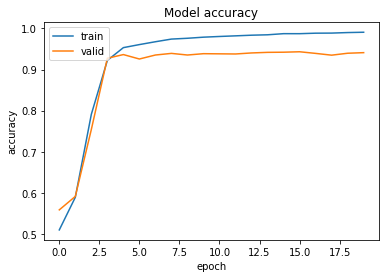

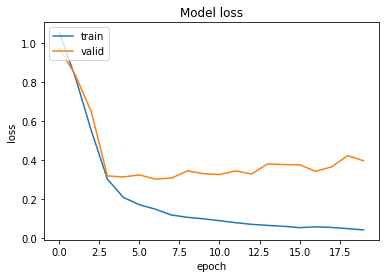

In [33]:
from matplotlib import pyplot as plt

def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
#If you need...
display_history(history)

A modell jóságmutatói

87/87 [==============================] - 1s 6ms/step
Accuracy: 0.9432
Auc: 0.9882
Detail:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       626
           1       0.97      0.97      0.97       567
           2       0.92      0.92      0.92       531
           3       0.95      0.94      0.94      1057

    accuracy                           0.94      2781
   macro avg       0.94      0.94      0.94      2781
weighted avg       0.94      0.94      0.94      2781



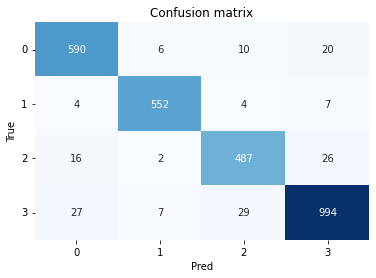

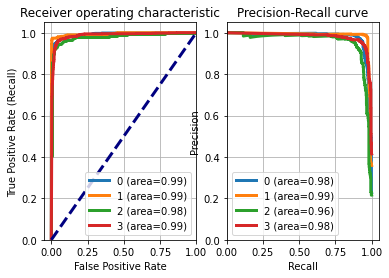

In [35]:

## test
predicted_prob = model.predict(tfidf_valid_dr)
predicted = predicted_prob.argmax(axis=-1) 

classes = np.unique(ecomm_valid.category_num)
y_test_array = pd.get_dummies(ecomm_valid.category_num, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(ecomm_valid.category_num, predicted)
auc = metrics.roc_auc_score(ecomm_valid.category_num, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,4))
print("Auc:", round(auc,4))
print("Detail:")
print(metrics.classification_report(ecomm_valid.category_num, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(ecomm_valid.category_num, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Mentsük el a modellt.

In [36]:
model.save('ecomm_model.h5')  # creates a HDF5 file 'my_model.h5'

Mentsük el a driveba is

In [37]:
model.save('/content/gdrive/MyDrive/Colab_models/ecomm_model.h5')

Teljesítmény a test adatokon.

87/87 [==============================] - 0s 4ms/step
Accuracy: 0.9482
Auc: 0.9886
Detail:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       625
           1       0.98      0.97      0.98       568
           2       0.92      0.93      0.93       531
           3       0.95      0.95      0.95      1056

    accuracy                           0.95      2780
   macro avg       0.95      0.95      0.95      2780
weighted avg       0.95      0.95      0.95      2780



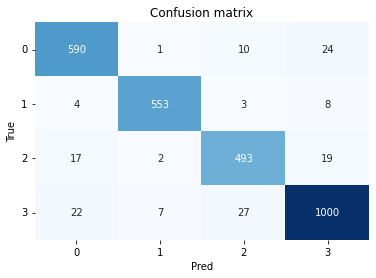

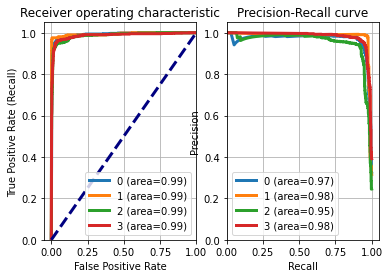

In [43]:
## test
predicted_prob = model.predict(tfidf_test_dr)
predicted = predicted_prob.argmax(axis=-1) 

classes = np.unique(ecomm_test.category_num)
y_test_array = pd.get_dummies(ecomm_test.category_num, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(ecomm_test.category_num, predicted)
auc = metrics.roc_auc_score(ecomm_test.category_num, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,4))
print("Auc:", round(auc,4))
print("Detail:")
print(metrics.classification_report(ecomm_test.category_num, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(ecomm_test.category_num, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Kategorizálás fastText felhasználásával

In [ ]:
! wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
! unzip v0.9.2.zip
! cd fastText-0.9.2
! pip install fastText

Az adatok átalakítása a fastText számára emészthető formára

In [39]:


ecomm_train["category_ft"] = ecomm_train["category"].str.replace(" & ", "_" ).apply(lambda x: '__label__' + x)
ecomm_valid["category_ft"] = ecomm_valid["category"].str.replace(" & ", "_" ).apply(lambda x: '__label__' + x)
ecomm_test["category_ft"] = ecomm_test["category"].str.replace(" & ", "_" ).apply(lambda x: '__label__' + x)

ecomm_train.head()

,category,description,category_num,length,description_clean,category_ft
953,Household,Tayyaba Enterprises Pure Sheesham Wooden Rocki...,3,679,tayyaba enterprise pure sheesham wooden rockin...,__label__Household
24365,Electronics,JBL GO Portable Wireless Bluetooth Speaker wit...,2,798,jbl go portable wireless bluetooth speaker mic...,__label__Electronics
2265,Household,Dkdas Steel Twin Bell Alarm Clock with Night L...,3,735,dkdas steel twin bell alarm clock night led li...,__label__Household
21410,Clothing & Accessories,AV2 Women Solid Feeding/Maternity/Nursing Nigh...,1,589,av2 woman solid feedingmaternitynursing nightd...,__label__Clothing_Accessories
8572,Household,Eureka Forbes 100-Watt Car Vaccum Cleaner (Whi...,3,1417,eureka forbes 100watt car vaccum cleaner white...,__label__Household


In [40]:
# Saving the CSV file as a text file to train/test the classifier
ecomm_train[['category_ft', 'description_clean']].to_csv('train.txt', 
                                                         index = False, 
                                                         sep = ' ',
                                                         header = None)

ecomm_valid[['category_ft', 'description_clean']].to_csv('valid.txt', 
                                                         index = False, 
                                                         sep = ' ',
                                                         header = None)

ecomm_test[['category_ft', 'description_clean']].to_csv('test.txt', 
                                                         index = False, 
                                                         sep = ' ',
                                                         header = None)



In [41]:
import fasttext

model_ft = fasttext.train_supervised('train.txt', epoch=20)

# Evaluating performance on the entire test file
model_ft.test('valid.txt')                      



(2781, 0.9446242358863718, 0.9446242358863718)

In [44]:
model_ft.test('test.txt')  

(2780, 0.9514388489208633, 0.9514388489208633)